In [134]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

df = pd.read_csv('data.csv', index_col = 'ID')     #'P' = Patient    'H' = Healthy
df['class'] = df['class'].astype('category')

print('--- CLASS DISTRIBUTION ---')
print(df['class'].value_counts())

--- CLASS DISTRIBUTION ---
class
P    89
H    85
Name: count, dtype: int64


<h4> OPTIMAL N PCA COMPONENTS </h4>
I will test for the optimal N PCA components for different models by measuring their precision score. Plots will be provided that display the mean scores along with the standard deviations to get insight in PCA performance throughout iterations. 

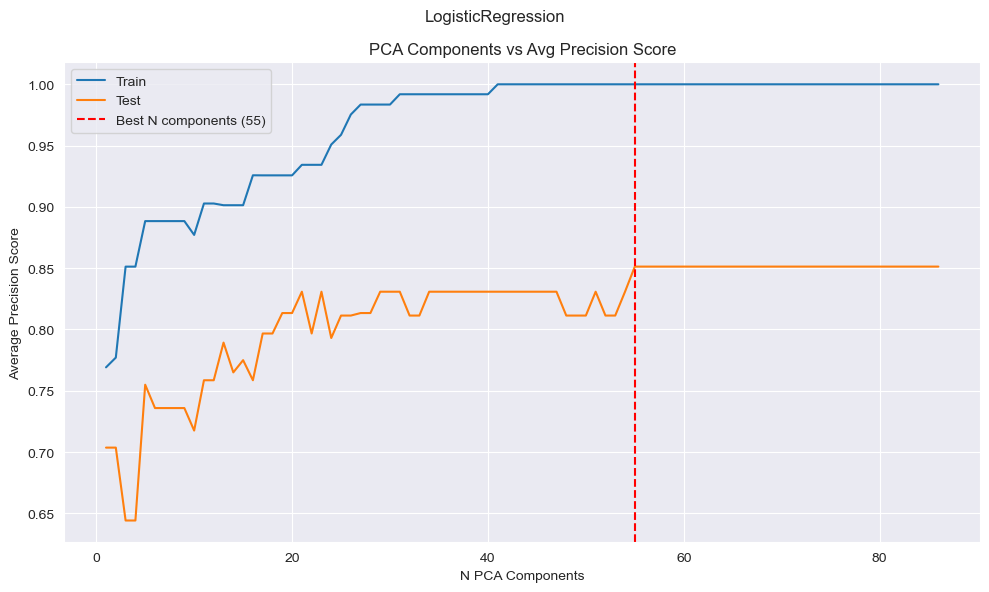

LogisticRegression best number of components: 55
LogisticRegression best average test score: 0.8513




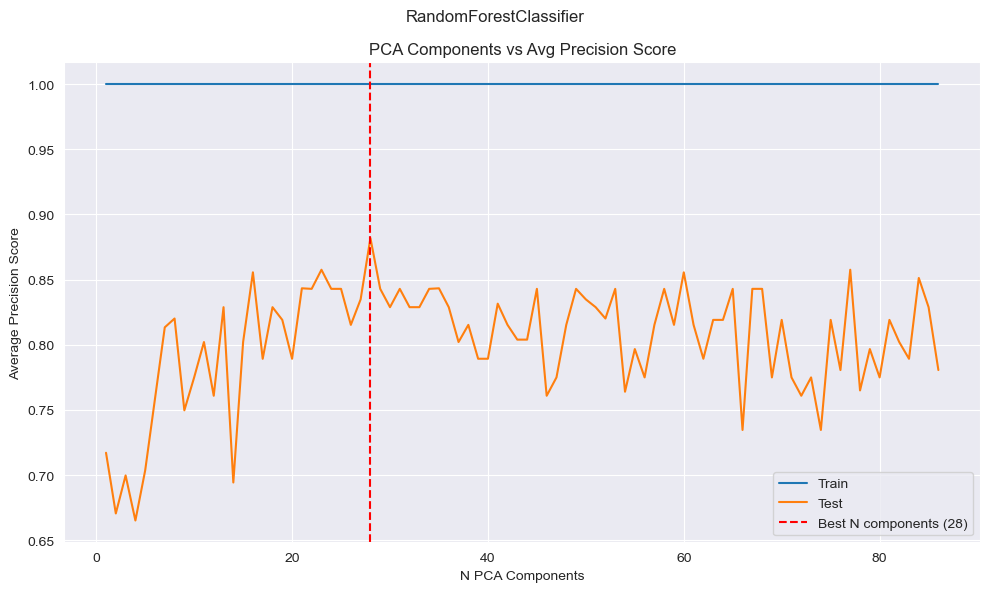

RandomForestClassifier best number of components: 28
RandomForestClassifier best average test score: 0.8819




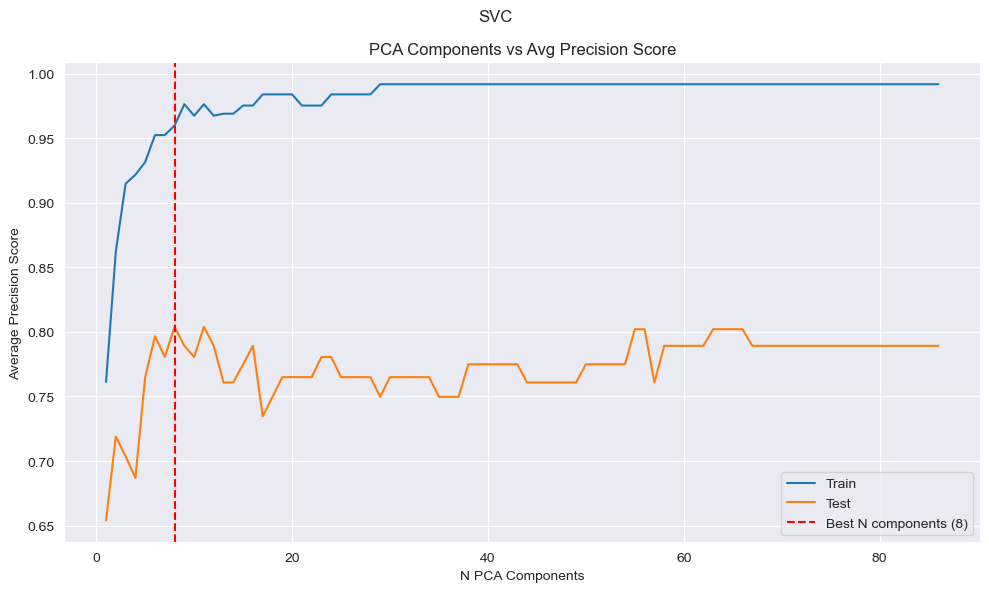

SVC best number of components: 8
SVC best average test score: 0.8039




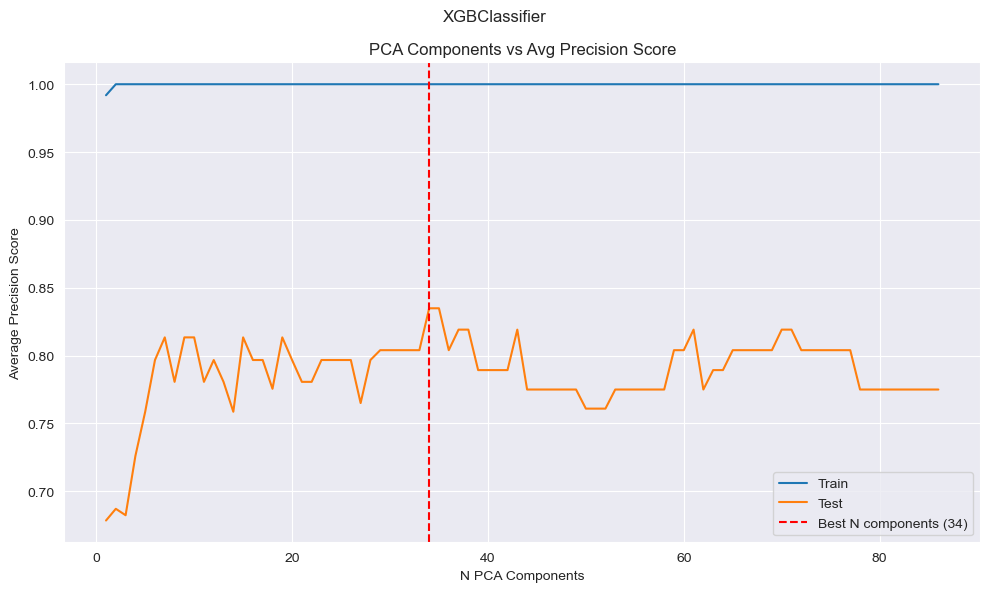

XGBClassifier best number of components: 34
XGBClassifier best average test score: 0.8348




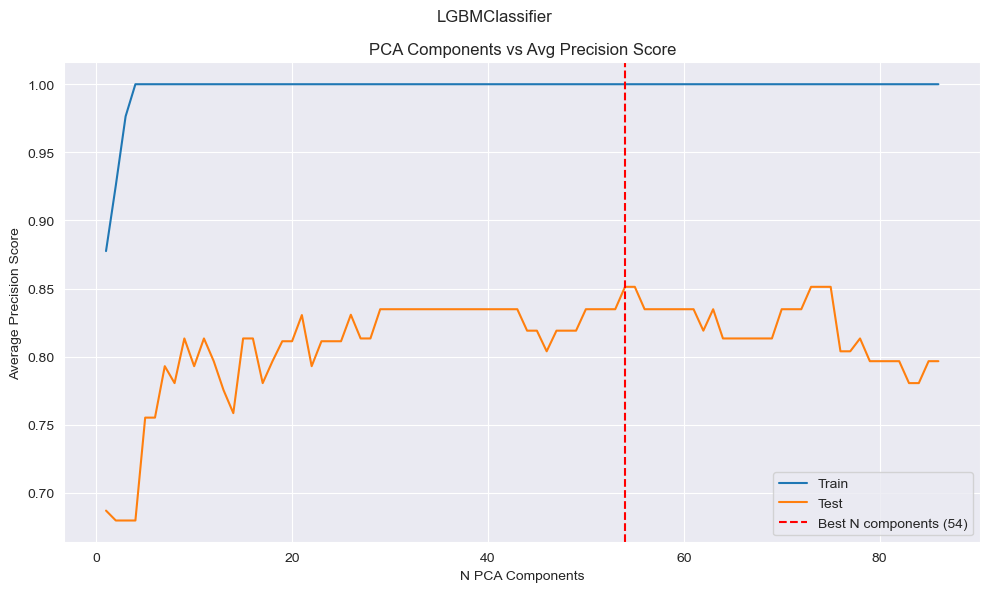

LGBMClassifier best number of components: 54
LGBMClassifier best average test score: 0.8513


                     name  n_components  test_score
0      LogisticRegression            55    0.851267
1  RandomForestClassifier            28    0.881896
2                     SVC             8    0.803934
3           XGBClassifier            34    0.834824
4          LGBMClassifier            54    0.851267


In [135]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style('darkgrid')

X = df.drop('class', axis=1)
y = LabelEncoder().fit_transform(df['class'])

scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X)

max_components = (min(X.shape[0], X.shape[1]) - 1) // 2

classifier_list = [
    LogisticRegression(random_state=1),
    RandomForestClassifier(random_state=1),
    SVC(random_state=1),
    XGBClassifier(random_state=1),
    LGBMClassifier(random_state=1, verbose=-1)
]

best_components = {}
scoring = 'precision'
n_splits = 5 

results = []

for clf in classifier_list:
    name = clf.__class__.__name__

    best_score = 0
    best_n_components = 0

    avg_train_scores = np.zeros(max_components)
    avg_test_scores = np.zeros(max_components)
    
    for _ in range(n_splits):
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, shuffle= True, test_size=0.3, stratify=y, random_state= 1)
        
        train_scores = []
        test_scores = []
        
        for n_components in range(1, max_components + 1):
            pca = PCA(n_components=n_components, random_state= 1)
            X_train_pca = pca.fit_transform(X_train)
            X_test_pca = pca.transform(X_test)
            
            clf.fit(X_train_pca, y_train)
            
            y_train_pred = clf.predict(X_train_pca)
            y_test_pred = clf.predict(X_test_pca)
            
            train_score = precision_score(y_train, y_train_pred, average='weighted')
            test_score = precision_score(y_test, y_test_pred, average='weighted')
            
            train_scores.append(train_score)
            test_scores.append(test_score)
        
        avg_train_scores += np.array(train_scores)
        avg_test_scores += np.array(test_scores)
    
    avg_train_scores /= n_splits
    avg_test_scores /= n_splits
    
    best_n_components = np.argmax(avg_test_scores) + 1
    best_score = np.max(avg_test_scores)
    
    best_components[name] = best_n_components
    
    results.append({
        'name': name,
        'n_components': best_n_components,
        'test_score': best_score
    })
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_components + 1), avg_train_scores, label='Train')
    plt.plot(range(1, max_components + 1), avg_test_scores, label='Test')
    plt.xlabel('N PCA Components')
    plt.ylabel(f'Average {scoring.capitalize()} Score')
    plt.axvline(best_n_components, color='red', linestyle='--', label=f'Best N components ({best_n_components})')
    plt.title(f'PCA Components vs Avg {scoring.capitalize()} Score')
    plt.suptitle(f'{name}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f'{name} best number of components: {best_n_components}')
    print(f'{name} best average test score: {round(best_score, 4)}\n\n')

results_df = pd.DataFrame(results)
print(results_df)

results_df_sorted = results_df.sort_values('test_score', ascending=False).reset_index(drop=True)

In [136]:
display(results_df_sorted)

,name,n_components,test_score
0,RandomForestClassifier,28,0.881896
1,LogisticRegression,55,0.851267
2,LGBMClassifier,54,0.851267
3,XGBClassifier,34,0.834824
4,SVC,8,0.803934


<h4> RESULTS </h4>
Since the dataset is small, I want to apply hyperparameter tuning to all models in order to get the optimal results

In [137]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from scipy.stats import randint, uniform 

rf_params = {
    'n_estimators': randint(50, 150), 
    'max_depth': [3, 5, 7, None], 
    'min_samples_split': randint(2, 8), 
    'min_samples_leaf': randint(1, 4)
}

lr_params = {
    'penalty': ['l2'],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'tol': uniform(0.0001, 0.1),
    'C': uniform(0.1, 10)
}

lgbm_params = {
    'boosting_type': ['gbdt', 'dart'], 
    'num_leaves': randint(20, 100),
    'max_depth': randint(3, 8),
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(50, 300),
    'min_child_samples': randint(20, 100),
    'subsample': uniform(0.5, 0.5), 
    'colsample_bytree': uniform(0.5, 0.5),  
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

xgb_params = {
    'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(2, 8),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

svc_params = {
    'C': uniform(0.1, 10),
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': randint(2, 5),
    'gamma': ['scale', 'auto']
}


hyperparam_list = [
    (RandomForestClassifier(random_state=1), rf_params),
    (LogisticRegression(random_state=1, max_iter=1000), lr_params),
    (LGBMClassifier(random_state=1, verbose=-1), lgbm_params),
    (XGBClassifier(random_state=1), xgb_params),
    (SVC(random_state=1), svc_params)
]

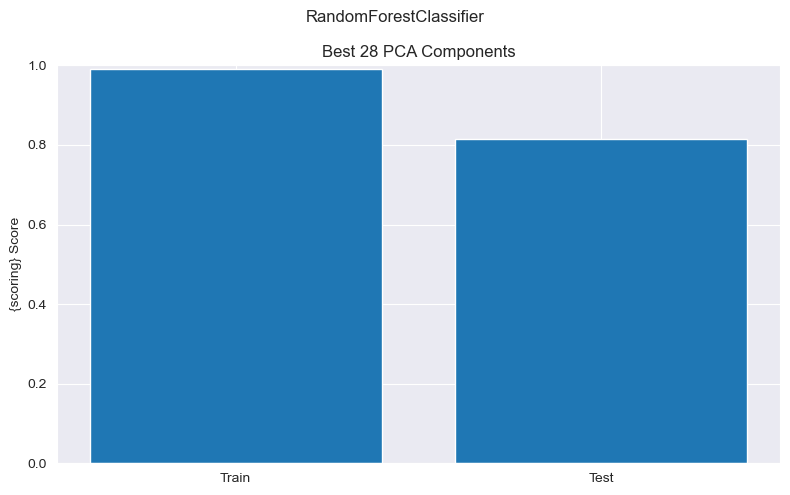

Best parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 148}
Train score: 0.9919
Test score: 0.8153




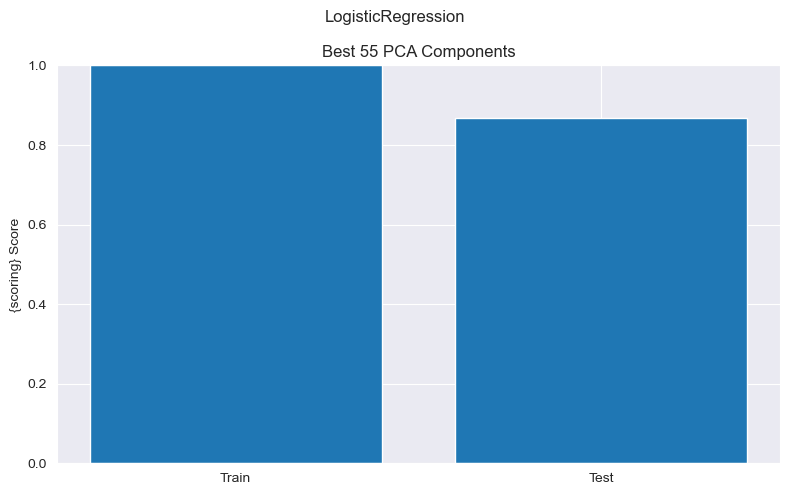

Best parameters: {'C': 9.133701664788672, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.013102857211827768}
Train score: 1.0
Test score: 0.8685




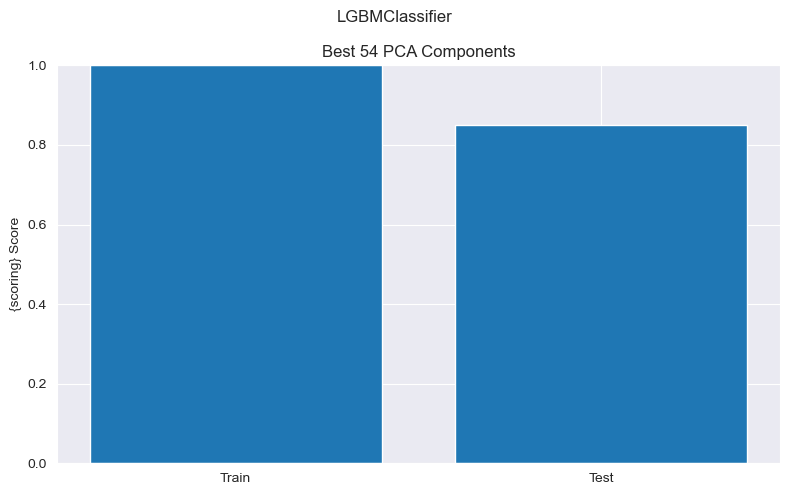

Best parameters: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8675329816443347, 'learning_rate': 0.16443560590864936, 'max_depth': 7, 'min_child_samples': 23, 'n_estimators': 234, 'num_leaves': 66, 'reg_alpha': 0.7563353922144794, 'reg_lambda': 0.3976112823946484, 'subsample': 0.9626000544304147}
Train score: 1.0
Test score: 0.8513




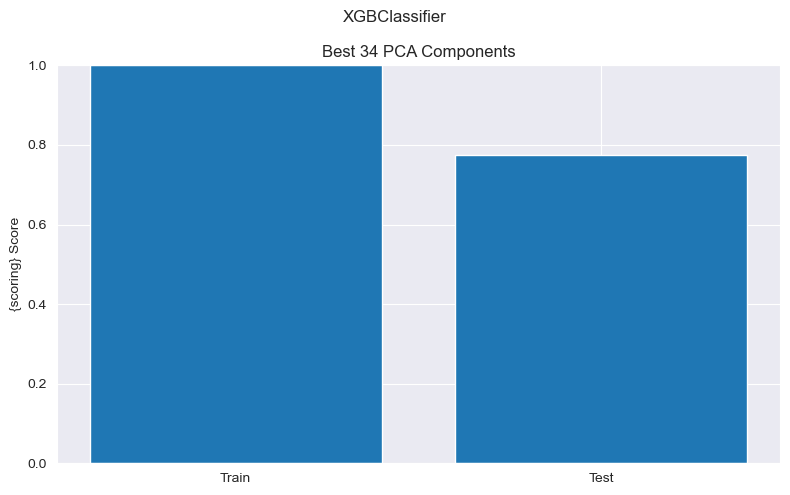

Best parameters: {'colsample_bytree': 0.652011428847311, 'learning_rate': 0.013873391574059415, 'max_depth': 5, 'n_estimators': 216, 'reg_alpha': 0.21162811600005904, 'reg_lambda': 0.2655466593722262, 'subsample': 0.7966292637121353}
Train score: 1.0
Test score: 0.7749




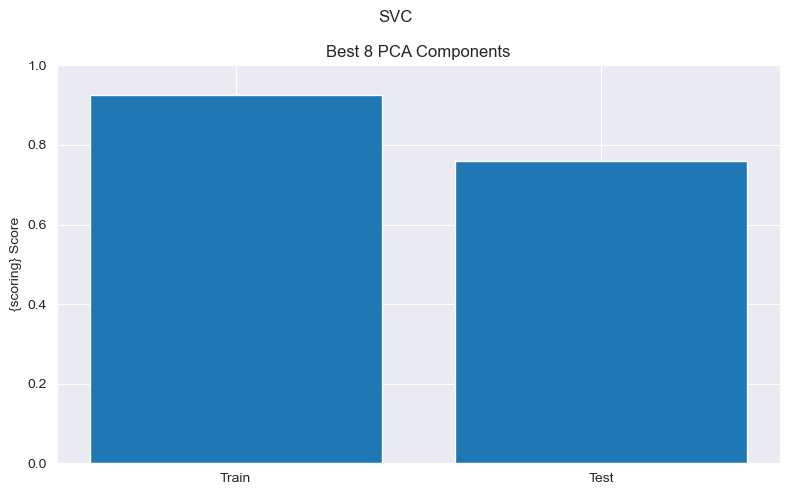

Best parameters: {'C': 1.9626021137767091, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
Train score: 0.925
Test score: 0.7609




,name,n_components,test_score
0,LogisticRegression,55,0.8685
1,LGBMClassifier,54,0.8513
2,RandomForestClassifier,28,0.8153
3,XGBClassifier,34,0.7749
4,SVC,8,0.7609


In [138]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.3, stratify= y, random_state= 1)

cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 1)
n_iter = 35
scoring = 'precision'

final_results = []

for clf, params in hyperparam_list: 
    name = clf.__class__.__name__
    n_components = results_df_sorted[results_df_sorted['name']== name]['n_components'].values[0]

    pca = PCA(n_components= n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    random_search = RandomizedSearchCV(clf, params, n_iter = n_iter, cv = cv, scoring = scoring, n_jobs = -1, random_state= 1)
    random_search.fit(X_train_pca, y_train)
    
    best_model = random_search.best_estimator_
    
    y_train_pred = best_model.predict(X_train_pca)
    y_test_pred = best_model.predict(X_test_pca)
    
    train_score = round(precision_score(y_train, y_train_pred, average = 'weighted'),4)
    test_score = round(precision_score(y_test, y_test_pred, average = 'weighted'),4)
    
    final_results.append({
        'name': name, 
        'n_components': n_components, 
        'test_score': test_score, 
    })
    
    plt.figure(figsize= (8, 5))
    plt.bar(['Train','Test'], [train_score, test_score])
    plt.title(f'Best {n_components} PCA Components')
    plt.suptitle(f'{name}')
    plt.ylabel('{scoring} Score')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
    
    print(f"Best parameters: {random_search.best_params_}")
    print(f"Train score: {train_score}")
    print(f"Test score: {test_score}")
    print("\n")
    
final_results_df = pd.DataFrame(final_results)
final_results_df_sorted = final_results_df.sort_values('test_score', ascending=False).reset_index(drop=True)
display(final_results_df_sorted)

<h4> RESULTS </h4>
Interstingly enough, hyperparameter tuning made all models perform worse than before the tuning. My theory is that this is because the PCA iteration process was optimal for the base models without any tweaked hyperparameters. For my new approach, I will take the single best-performing model (Random Forest), and iterate throughout it with PCA whilst applying RandomizedSearchCV. Hopefully, this will produce the best possible model. 

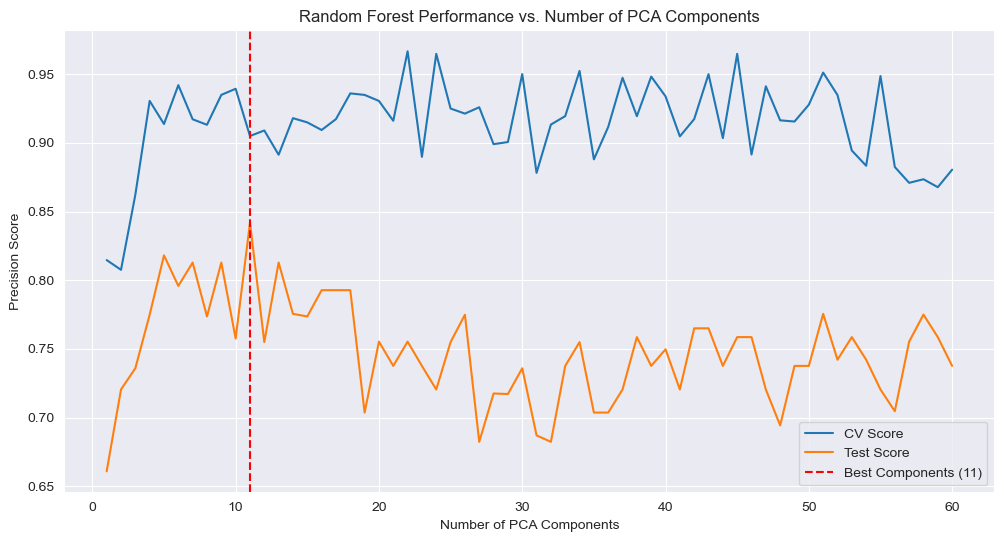


Best number of components: 11
Best test score: 0.8418
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 133}

Final model test score: 0.8418


In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from scipy.stats import randint

# Assuming X and y are already defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the range of PCA components to try
max_components = min(X_train.shape[0], X_train.shape[1])
n_components_range = range(1, (max_components // 2) + 1)

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5)
}

# Initialize lists to store results
cv_scores = []
test_scores = []
best_params_list = []

# Iterate through different numbers of PCA components
for n_components in n_components_range:
    
    # Apply PCA
    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    # Perform RandomizedSearchCV
    rf = RandomForestClassifier(random_state=42)
    random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=20, 
                                       cv=3, scoring='precision', n_jobs=-1, random_state=42)
    random_search.fit(X_train_pca, y_train)
    
    # Store the best CV score
    cv_scores.append(random_search.best_score_)
    
    # Evaluate on test set
    y_pred = random_search.best_estimator_.predict(X_test_pca)
    test_score = precision_score(y_test, y_pred, average='weighted')
    test_scores.append(test_score)
    
    # Store best parameters
    best_params_list.append(random_search.best_params_)

# Find the best number of components
best_index = np.argmax(test_scores)
best_n_components = n_components_range[best_index]
best_score = test_scores[best_index]
best_params = best_params_list[best_index]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(n_components_range, cv_scores, label='CV Score')
plt.plot(n_components_range, test_scores, label='Test Score')
plt.axvline(x=best_n_components, color='r', linestyle='--', 
            label=f'Best Components ({best_n_components})')
plt.xlabel('Number of PCA Components')
plt.ylabel('Precision Score')
plt.title('Random Forest Performance vs. Number of PCA Components')
plt.legend()
plt.show()

print(f"\nBest number of components: {best_n_components}")
print(f"Best test score: {best_score:.4f}")
print(f"Best parameters: {best_params}")

# Optional: Train final model with best configuration
final_pca = PCA(n_components=best_n_components, random_state=42)
X_train_pca_final = final_pca.fit_transform(X_train_scaled)
X_test_pca_final = final_pca.transform(X_test_scaled)

final_rf = RandomForestClassifier(random_state=42, **best_params)
final_rf.fit(X_train_pca_final, y_train)
final_pred = final_rf.predict(X_test_pca_final)
final_score = precision_score(y_test, final_pred, average='weighted')

print(f"\nFinal model test score: {final_score:.4f}")

Baseline Random Forest CV Score: 0.7969 (+/- 0.1566)
Tuned Random Forest CV Score: 0.8327 (+/- 0.1374)
Best parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Best PCA + RF CV Score: 0.9067
Best number of components: 47


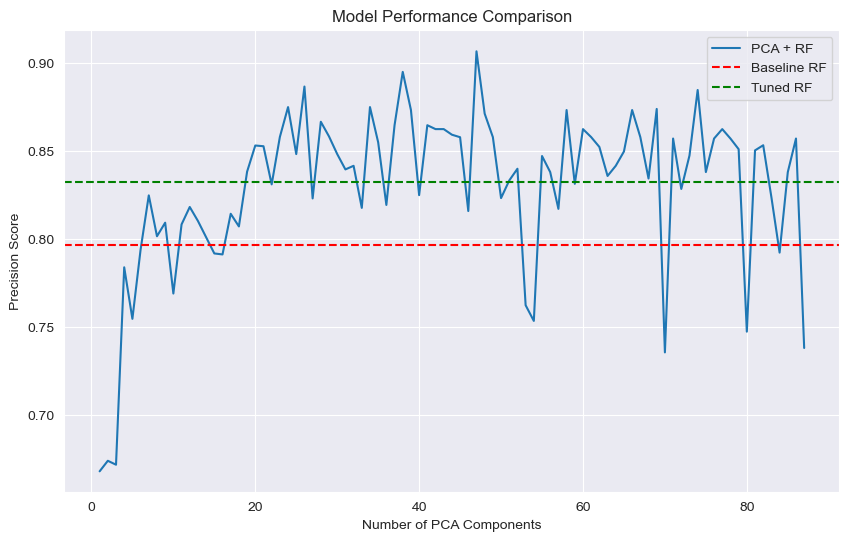

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Assuming X and y are already defined
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Function to evaluate model
def evaluate_model(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv, scoring='precision')
    return scores.mean(), scores.std()

# Baseline Random Forest without PCA
rf = RandomForestClassifier(random_state=42)
baseline_score, baseline_std = evaluate_model(rf, X_scaled, y)
print(f"Baseline Random Forest CV Score: {baseline_score:.4f} (+/- {baseline_std:.4f})")

# Tuned Random Forest without PCA
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=20, 
                                   cv=5, scoring='precision', n_jobs=-1, random_state=42)
random_search.fit(X_scaled, y)
tuned_score, tuned_std = evaluate_model(random_search.best_estimator_, X_scaled, y)
print(f"Tuned Random Forest CV Score: {tuned_score:.4f} (+/- {tuned_std:.4f})")
print(f"Best parameters: {random_search.best_params_}")

# PCA + Random Forest
pca_scores = []
n_components_range = range(1, min(X.shape[0], X.shape[1]) // 2 + 1)

for n_components in n_components_range:
    pca = PCA(n_components=n_components, random_state=42)
    pipeline = Pipeline([('pca', pca), ('rf', RandomForestClassifier(random_state=42))])
    score, _ = evaluate_model(pipeline, X_scaled, y)
    pca_scores.append(score)

best_n_components = n_components_range[np.argmax(pca_scores)]
best_pca_score = max(pca_scores)

print(f"Best PCA + RF CV Score: {best_pca_score:.4f}")
print(f"Best number of components: {best_n_components}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, pca_scores, label='PCA + RF')
plt.axhline(y=baseline_score, color='r', linestyle='--', label='Baseline RF')
plt.axhline(y=tuned_score, color='g', linestyle='--', label='Tuned RF')
plt.xlabel('Number of PCA Components')
plt.ylabel('Precision Score')
plt.title('Model Performance Comparison')
plt.legend()
plt.show()